In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xbbg import blp
from pandas.tseries.offsets import *

devCcy =  ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK']
revL = ['NZD', 'EUR', 'AUD', 'GBP']

basket=devCcy

#########################################

startDate = '2010-01-01'
endDate = '2023-12-31'

# startDate = '2024-07-01'
# endDate = '2024-12-31'

startDate = '2012-01-01'
# endDate = '2025-01-31'
endDate = '2025-04-18'


dr = pd.date_range(
    start=pd.to_datetime(startDate),
    end=pd.to_datetime(endDate),
    freq=BDay()
)   


#########################################
spot = pd.read_csv(r'@@spot.csv')
tmpL = [spot]

for i in tmpL:
    i.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
    i.index = i['Date']
    i.drop(columns='Date', inplace=True)
    i.index = pd.DatetimeIndex(i.index)

for i in spot.columns:
    if i in revL:
        spot[i] = 1 / spot[i] 

spot = spot.reindex(dr).ffill()


# tmpL = [f'{i}2Y Govt' for i in ['GECU', 'GTJPY', 'GTGBP', 'GTCHF','GTAUD','GTCAD','GTNZD','GTSEK'] if i != 'GECU']
bondTickerShort = ['GECU2YR Index',
 'GTJPY2Y Govt',
 'GTGBP2Y Govt',
 'GTCHF2Y Govt',
 'GTAUD2Y Govt',
 'GTCAD2Y Govt',
 'GTNZD2Y Govt',
 'GTSEK2Y Govt',
 'USGG2YR Index']


bontTickerMedium = ['GECU5YR Index',
 'GTJPY5Y Govt',
 'GTGBP5Y Govt',
 'GTCHF5Y Govt',
 'GTAUD5Y Govt',
 'GTCAD5Y Govt',
 'GTNZD5Y Govt',
 'GTSEK5Y Govt',
 'USGG5YR Index']

bondTickerLong = ['GECU10YR Index',
 'GTJPY10Y Govt',
 'GTGBP10Y Govt',
 'GTCHF10Y Govt',
 'GTAUD10Y Govt',
 'GTCAD10Y Govt',
 'GTNZD10Y Govt',
 'GTSEK10Y Govt',
 'USGG10YR Index']

def resample_with_business_day_adjustment(df, freq='W-Fri', agg_func='ffill'):
    # Step 1: Resample to desired frequency
    resampled = df.resample(freq).agg(agg_func)
    
    # Step 2: Adjust index to nearest previous business day
    adjusted_index = resampled.index.to_series().apply(lambda x: x - pd.Timedelta(days=1) if x.dayofweek >= 5 else x) # day of week 從 0 開始
    adjusted_index = pd.to_datetime(adjusted_index.dt.date)  # Remove time component
    adjusted_index = adjusted_index.apply(lambda x: pd.date_range(end=x, periods=1, freq='B')[0])
    
    resampled.index = adjusted_index
    
    # Step 3: Resample back to business days
    return resampled

bondDfShort = pd.DataFrame(index=dr, columns=bondTickerShort)
for t in bondDfShort.columns:
    #print(t)
    bondDfShort[t] = blp.bdh(tickers=t, flds=["PX_LAST"], start_date=startDate, end_date=endDate).reindex(dr).ffill().shift(1)

bondDfShort.columns = devCcy+['USD']

bonDfMedium = pd.DataFrame(index=dr, columns=bontTickerMedium)
for t in bonDfMedium.columns:
    # print
    bonDfMedium[t] = blp.bdh(tickers=t, flds=["PX_LAST"], start_date=startDate, end_date=endDate).reindex(dr).ffill().shift(1)
bonDfMedium.columns = devCcy+['USD']

bondDfLong = pd.DataFrame(index=dr, columns=bondTickerLong)
for t in bondDfLong.columns:
    bondDfLong[t] = blp.bdh(tickers=t, flds=["PX_LAST"], start_date=startDate, end_date=endDate).reindex(dr).ffill().shift(1)
bondDfLong.columns = devCcy+['USD']

bondDfCurvy = 2*bonDfMedium - (bondDfShort + bondDfLong)

# bondDfCurvy = bondDfCurvy.sub(bondDfCurvy['USD'], axis=0).drop('USD', axis=1)

bondDfCurvy2 = bondDfCurvy.copy()


rollWindow = 60 
bondDfCurvy = (bondDfCurvy - bondDfCurvy.rolling(window=rollWindow).mean())/bondDfCurvy.rolling(window=rollWindow).std()
bondDfCurvyWeek = resample_with_business_day_adjustment(bondDfCurvy)
bondDfCurvyWeekRank = bondDfCurvyWeek.rank(axis=1) # rank 越大，curvature 越大

rankWithUSD = bondDfCurvyWeekRank.copy()
rankNoUSD = bondDfCurvyWeekRank.drop(columns=['USD'])

rankDf = rankNoUSD.copy()
low30 = rankDf.quantile(.20, axis=1)
top30 = rankDf.quantile(.80, axis=1)

low = rankDf[rankDf.lt(low30, axis=0)]
medium = rankDf[(rankDf.gt(low30, axis=0) & (rankDf.lt(top30, axis=0)))]
high = rankDf[rankDf.gt(top30, axis=0)]

low.fillna(0, inplace=True)
medium.fillna(0, inplace=True)
high.fillna(0, inplace=True)


def replaceVal(row):
    return np.array([row.replace(x, 1/(row[row!=0].count()), inplace=True) for x in row if x!= 0])

for i in [low, medium, high]:
    i = i.apply(replaceVal, axis=1)

# signalDf = low*1+high*-1 # 排名最高者short該貨幣
signalDf = low*1+high*-1 # 排名最高者short該貨幣
# signalDf = low*1+high*0

signalDf = signalDf/2

maWindow = 20

bondCurvyMA = bondDfCurvy2.rolling(window=maWindow).mean()

def updateSignal_MA(col):
    for idx in col.index:
        # print(idx)
        # print(col[idx])
        if (col[idx] < 0) and (bondDfCurvy2.loc[idx, 'USD'] > bondCurvyMA.loc[idx, 'USD']): # 買非美貨幣但目前USD yield curve flatten -> should not sell USD
            col[idx] = col[idx] / 2
            # col[idx] = col[idx] / 2
        elif (col[idx] > 0) and (bondDfCurvy2.loc[idx, 'USD'] < bondCurvyMA.loc[idx, 'USD']): # 做多美元
            col[idx] = col[idx]
    return col

tmp = signalDf.copy()
tmp.apply(updateSignal_MA, axis=0)

# for i in tmp.columns:
#     if i in revL:
#         tmp[i] = -1 * tmp[i]
# for i in signalDf.columns:
#     if i in revL:
#         signalDf[i] = -1 * signalDf[i]
# drop the first row

tmp.to_csv('curvySignal_MA.csv')



In [29]:
btDailyRet.tail()

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK
2025-04-14,-0.002288,0.001747,-0.007499,0.002323,-0.016228,-0.004554,-0.013458,-0.011935
2025-04-15,0.002897,0.001535,-0.004405,-0.002697,-0.006482,0.001732,-0.007320,0.005493
2025-04-16,-0.002642,-0.008445,-0.004537,-0.002581,0.002513,0.003881,-0.000169,0.007632
2025-04-17,0.000878,0.005529,0.003086,0.005013,0.000000,-0.003028,0.000169,-0.006409
2025-04-18,0.000615,-0.003511,-0.001737,0.000489,-0.003150,-0.000433,-0.001859,-0.012722


,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe
2012,1.10,0.14,1.96,0.465
2013,1.57,0.24,3.48,0.395
2014,-0.02,0.18,2.37,-0.005
2015,12.53,0.33,1.97,2.293
2016,5.16,0.21,2.07,1.497
2017,0.48,0.18,2.96,0.159
2018,1.07,0.16,2.40,0.407
2019,2.34,0.17,1.42,0.853
2020,3.46,0.23,2.28,0.906
2021,1.60,0.13,2.75,0.723


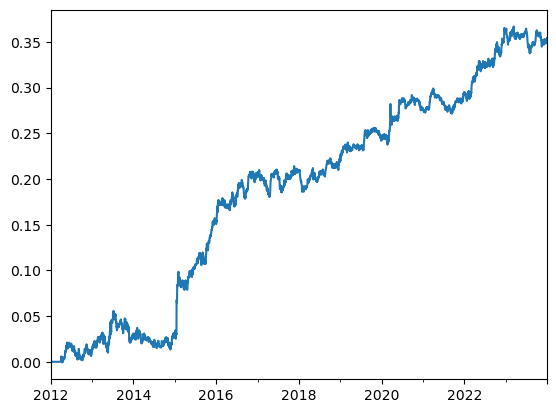

In [30]:
def getStats(totalCount, dailyS):
    s = pd.Series()

    if totalCount >= 252:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * 252
        s['Std'] = (dailyS[0:].std()) * np.sqrt(252)
    else:
        s['Mean'] = (dailyS[0:].sum()) / totalCount * totalCount
        s['Std'] = (dailyS[0:].std()) * np.sqrt(totalCount)

    s['Sharpe'] = s['Mean'] / s['Std']
    # mddForPlot = maxDDVer3(cumS)[0]
    # periodHigh = maxDDVer3(cumS)[1]
    # s['MDD'] = np.min(mddForPlot)
                                                                                                 
    return s


def calculate_detailed_mdd(daily_returns):
    cumulative_returns = daily_returns.cumsum()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    mdd_end_idx = drawdown.idxmax()
    mdd_value = drawdown[mdd_end_idx]
    mdd_start_idx = running_max.loc[:mdd_end_idx].idxmax()
    mdd_duration = (mdd_end_idx - mdd_start_idx).days
    return {
        "mdd_value": mdd_value,
        "mdd_start_date": mdd_start_idx,
        "mdd_end_date": mdd_end_idx,
        "mdd_duration": mdd_duration
    }



#delL = ['ZAR']
delL = []
test = [i for i in basket if i not in delL]
# btSpot = spot[basket].dropna()
btSpot = spot[basket]

# generate daily return
btDailyRet = btSpot.apply(lambda col: (col-col.shift(1))/col, axis=0)

btDailyRet = btDailyRet[basket]


portDailyChange = btDailyRet * tmp.reindex(dr).ffill().shift(1)
portDailyChange = portDailyChange[portDailyChange.index < '2024-01-01']
# portDailyChange = portDailyChange[portDailyChange.index > '2024-01-01']
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])

# yearlyRes = pd.DataFrame(index=portDailyChange.index.year.unique())
yearlyRes = pd.DataFrame()

yearlyRes['return(%)'] = round(portDailyChange['port'].resample('YE').sum().reset_index(drop=True) * 100, 2)
yearlyRes['dailyStd(%)'] = round(portDailyChange['port'].resample('YE').std().reset_index(drop=True)* 100, 2)
yearlyRes['yearlyMDD(%)'] = round(portDailyChange['port'].resample('YE').apply(lambda x: calculate_detailed_mdd(x)['mdd_value']).reset_index(drop=True)* 100, 2)
yearlyRes['yearlySharpe'] = round(portDailyChange['port'].resample('YE').apply(lambda x: getStats(x.shape[0], x)['Sharpe']).reset_index(drop=True), 3)
yearlyRes.index = portDailyChange.index.year.unique()
yearlyRes.loc['回測期間', 'return(%)'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Mean']*100, 2)
yearlyRes.loc['回測期間', 'dailyStd(%)'] = round(portDailyChange['port'].std()* 100, 2)
yearlyRes.loc['回測期間', 'yearlyMDD(%)'] = round(calculate_detailed_mdd(portDailyChange['port'])['mdd_value'] * 100, 2)
yearlyRes.loc['回測期間', 'yearlySharpe'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Sharpe'], 3)
yearlyRes

In [33]:
tmp.reindex(dr).ffill().tail()

,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK
2025-04-14,0.0,0.25,0.25,-0.125,0.0,-0.125,0.00,0.0
2025-04-15,0.0,0.25,0.25,-0.125,0.0,-0.125,0.00,0.0
2025-04-16,0.0,0.25,0.25,-0.125,0.0,-0.125,0.00,0.0
2025-04-17,0.0,0.25,0.25,-0.125,0.0,-0.125,0.00,0.0
2025-04-18,0.0,0.00,0.25,-0.250,0.0,-0.250,0.25,0.0


,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe
2024,3.51,0.15,1.27,1.460
2025,1.24,0.25,1.50,0.552
回測期間,3.53,0.18,1.50,1.260


C:\Users\Blair Lin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Blair Lin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Blair Lin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Blair Lin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Blair Lin\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from 

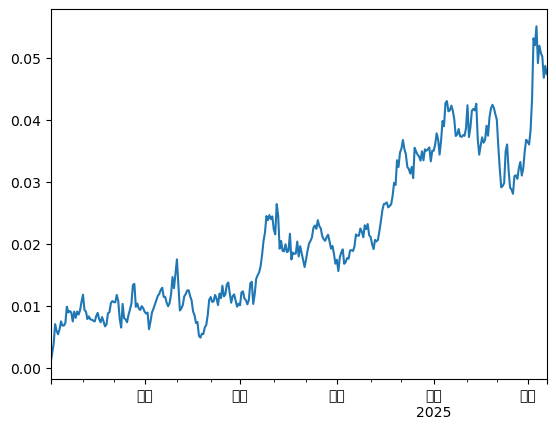

In [34]:
portDailyChange = btDailyRet * tmp.reindex(dr).ffill().shift(1)

portDailyChange = portDailyChange[portDailyChange.index > '2024-01-01']
portDailyChange['port'] = portDailyChange.sum(axis=1)
portDailyChange['port'].cumsum().plot()

getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])

# yearlyRes = pd.DataFrame(index=portDailyChange.index.year.unique())
yearlyRes = pd.DataFrame()

yearlyRes['return(%)'] = round(portDailyChange['port'].resample('YE').sum().reset_index(drop=True) * 100, 2)
yearlyRes['dailyStd(%)'] = round(portDailyChange['port'].resample('YE').std().reset_index(drop=True)* 100, 2)
yearlyRes['yearlyMDD(%)'] = round(portDailyChange['port'].resample('YE').apply(lambda x: calculate_detailed_mdd(x)['mdd_value']).reset_index(drop=True)* 100, 2)
yearlyRes['yearlySharpe'] = round(portDailyChange['port'].resample('YE').apply(lambda x: getStats(x.shape[0], x)['Sharpe']).reset_index(drop=True), 3)
yearlyRes.index = portDailyChange.index.year.unique()
yearlyRes.loc['回測期間', 'return(%)'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Mean']*100, 2)
yearlyRes.loc['回測期間', 'dailyStd(%)'] = round(portDailyChange['port'].std()* 100, 2)
yearlyRes.loc['回測期間', 'yearlyMDD(%)'] = round(calculate_detailed_mdd(portDailyChange['port'])['mdd_value'] * 100, 2)
yearlyRes.loc['回測期間', 'yearlySharpe'] = round(getStats(totalCount=portDailyChange['port'].dropna().shape[0], dailyS=portDailyChange['port'])['Sharpe'], 3)
yearlyRes